In [12]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))
import xarray as xr
import glob
import matplotlib.pyplot as plt
import numpy as np
import collections
from scipy.stats import linregress
import pandas as pd
# import utils as les_utils
from uwtrajectory import les_utils
import matplotlib as mpl
from uwtrajectory import unified_traj_data as utd
import pytz
import datetime as dt
%load_ext autoreload
%autoreload 2
print('hello world')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
hello world


In [3]:

def as_datetime(date, timezone=pytz.UTC):
    "Converts all datetimes types to datetime.datetime with TZ = UTC"
    def to_dt(d, timezone):
        """does all the heavy lifting
        """
        supported_types = (np.datetime64, dt.datetime)
        if not isinstance(d, supported_types):
            raise TypeError('type not supported: {}'.format(type(d)))
        if isinstance(d, np.datetime64):
            # TODO: add timezoneawareness here
            ts = (d - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
            d = dt.datetime.utcfromtimestamp(ts)
        if isinstance(d, pd.Timestamp):
            d = d.to_datetime()
        if isinstance(d, dt.datetime):
            if d.tzinfo is None:
                return(d.replace(tzinfo=timezone))
            else:
                return(d.astimezone(timezone))

    if isinstance(date, (collections.Sequence, np.ndarray)):
        return np.array([to_dt(x, timezone) for x in date])
    return to_dt(date, timezone)
    
    
def gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [4]:
all_files = glob.glob('/home/disk/eos4/jkcm/Data/CSET/Lagrangian_project/trajectory_files/rf*.nc')

ds = xr.open_dataset(all_files[8])
if True:
    box_degrees = 2
    lats, lons, times = ds.lat.values, ds.lon.values, as_datetime(ds.time.values)
    unique_days = set([as_datetime(i).date() for i in times])
    files = [os.path.join("/home/disk/eos4/jkcm/Data/MERRA/3h/", "more_vertical", "MERRA2_400.inst3_3d_aer_Nv.{:%Y%m%d}.nc4.nc4".format(i))
             for i in unique_days]
    
    with xr.open_mfdataset(sorted(files), combine='by_coords') as merra_data:
    
        # merra_data = merra_data.sel(lat=slice(np.min(lats)-2, np.max(lats)+2), lon=slice(np.min(lons)-2, np.max(lons)+2))
        rho = []
        var_shape = merra_data['AIRDENS'].isel(time=0, lat=0, lon=0).shape
        for (lat, lon, time) in zip(lats, lons, times):
                if lat > np.max(merra_data.coords['lat']) or lat < np.min(merra_data.coords['lat']) or \
                    lon > np.max(merra_data.coords['lon']) or lon < np.min(merra_data.coords['lon']):
                    print(f'out of range of data" {lat}, {lon}, {time}')
                    print(merra_data.coords['lat'])
                    print(merra_data.coords['lon'])
                    raise ValueError()
                    vals.append(np.full(var_shape, float('nan'), dtype='float'))
                    continue
                x = merra_data['AIRDENS'].sel(lon=slice(lon - box_degrees/2, lon + box_degrees/2),
                                        lat=slice(lat - box_degrees/2, lat + box_degrees/2))
                z = x.sel(method='nearest', time=time, tolerance=np.timedelta64(2, 'h'))
                #this applies a 2D gaussian the width of z, i.e. sigma=box_degrees
                gauss_shape = tuple([v for v,i in zip(z.shape,z.dims) if i in ['lat', 'lon'] ])
                gauss = gauss2D(shape=gauss_shape, sigma=gauss_shape[-1])
                filtered = z * gauss
                rho.append(filtered.sum(dim=('lat', 'lon')).values)
        ds['MERRA_AIRDENS'] = (tuple(x for x in merra_data['AIRDENS'].dims if x not in ['lat', 'lon']), np.array(rho), merra_data['AIRDENS'].attrs)
    

/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
/home/disk/p/jkcm/anaconda3/envs/classified-cset/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  # This is added back by InteractiveShellApp.init_path()


In [5]:
  
    ds['MERRA_Na_tot_mass'] = ds.MERRA_OCPHILIC + ds.MERRA_OCPHOBIC + ds.MERRA_BCPHILIC + \
                              ds.MERRA_BCPHOBIC + ds.MERRA_SO4 + ds.MERRA_DU001 + ds.MERRA_DU002 +\
                              ds.MERRA_DU003 +ds.MERRA_DU004 + ds.MERRA_DU005 + ds.MERRA_SS001 + \
                              ds.MERRA_SS002 + ds.MERRA_SS003 + ds.MERRA_SS004 + ds.MERRA_SS005    
    
    # #akn=aitken = everything below 80nm
    # #acc = accumulution = everything between 80 and 1000
    # #crs=coarse = everything above 1000
    mass_acc_dict = {}
    mass_akn_dict = {}
    mass_crs_dict = {}
    num_acc_dict = {}
    num_akn_dict = {}
    num_crs_dict = {}
    
    for x in ['MERRA_OCPHILIC', 'MERRA_OCPHOBIC', 'MERRA_BCPHILIC', 'MERRA_BCPHOBIC', 'MERRA_SO4']:
        params = les_utils.merra_species_dict_colarco[x.split('_')[1]]
        data = ds[x]

        rho = ds.MERRA_AIRDENS.values 
        n0 = les_utils.get_n0(mass=data.values, density=params['density'], r_max=50, r_min=0.001, std_dev=params['geometric_std_dev'], mode_radius=params['mode_radius'])
        mass_acc_dict[x] = les_utils.get_m_subset(density=params['density'], n0=n0, r_min=0.08, r_max=1, std_dev=params['geometric_std_dev'], mode_radius=params['mode_radius'])
        mass_akn_dict[x] = les_utils.get_m_subset(density=params['density'], n0=n0, r_min=0.01, r_max=0.08, std_dev=params['geometric_std_dev'], mode_radius=params['mode_radius'])
        mass_crs_dict[x] = les_utils.get_m_subset(density=params['density'], n0=n0, r_min=1, r_max=params['upper'], std_dev=params['geometric_std_dev'], mode_radius=params['mode_radius'])
        num_acc_dict[x] = les_utils.get_n_subset(n0, r_min=0.08, r_max=1, std_dev=params['geometric_std_dev'], mode_radius=params['mode_radius'])
        num_akn_dict[x] = les_utils.get_n_subset(n0, r_min=0.01, r_max=0.08, std_dev=params['geometric_std_dev'], mode_radius=params['mode_radius'])
        num_crs_dict[x] = les_utils.get_n_subset(n0, r_min=1, r_max=params['upper'], std_dev=params['geometric_std_dev'], mode_radius=params['mode_radius'])
    
        ds[x+'_n0'] = (('time', 'lev'), n0*rho)


    mass_acc_attrs = {'long_name': 'accumulation mode aerosol mass',
                        'units': 'kg kg**-1'}
    mass_akn_attrs = {'long_name': 'aikten mode aerosol mass',
                        'units': 'kg kg**-1'}
    mass_crs_attrs = {'long_name': 'coarse mode aerosol mass',
                        'units': 'kg kg**-1'}

    ds['MERRA_acc_mass'] = (('time', 'lev'), np.sum(list(mass_acc_dict.values()), axis=0) + \
                                ds.MERRA_DU001.values + ds.MERRA_SS002.values + ds.MERRA_SS003.values,
                                mass_acc_attrs)
    ds['MERRA_akn_mass'] = (('time', 'lev'), np.sum(list(mass_akn_dict.values()), axis=0) + \
                                ds.MERRA_SS001.values,
                                mass_akn_attrs)
    ds['MERRA_crs_mass'] = (('time', 'lev'), np.sum(list(mass_crs_dict.values()), axis=0) + \
                                ds.MERRA_DU002.values + ds.MERRA_DU003.values + ds.MERRA_DU004.values + ds.MERRA_DU005.values + \
                                ds.MERRA_SS004.values + ds.MERRA_SS005.values,
                                mass_crs_attrs)
#     TODO set attrs for mode masses
    #setting aikten num: all the lognormal modes plus dust1 and SS1/2 nums
#     MERRA_DU001_num = 

#     ds['MERRA_akn_num'] = 
#     ds['MERRA_acc_num'] = 
#     ds['MERRA_crs_num'] = 

    if 'MERRA_MERRA_Na_tot_corr' in ds.data_vars.keys():
        ds['MERRA_Na_tot_corr'] = ds['MERRA_MERRA_Na_tot_corr']
        ds = ds.drop('MERRA_MERRA_Na_tot_corr')
    na_tot = ds['MERRA_Na_tot'].values
    
    

    ds['MERRA_Na_tot_mass'] = ds.MERRA_OCPHILIC + ds.MERRA_OCPHOBIC + ds.MERRA_BCPHILIC + \
                              ds.MERRA_BCPHOBIC + ds.MERRA_SO4 + ds.MERRA_DU001 + ds.MERRA_DU002 +\
                              ds.MERRA_DU003 +ds.MERRA_DU004 + ds.MERRA_DU005 + ds.MERRA_SS001 + \
                              ds.MERRA_SS002 + ds.MERRA_SS003 + ds.MERRA_SS004 + ds.MERRA_SS005

0.0212
0.13686516019711023
0.0118
0.049871942657269304
0.0695
0.3127082994315797


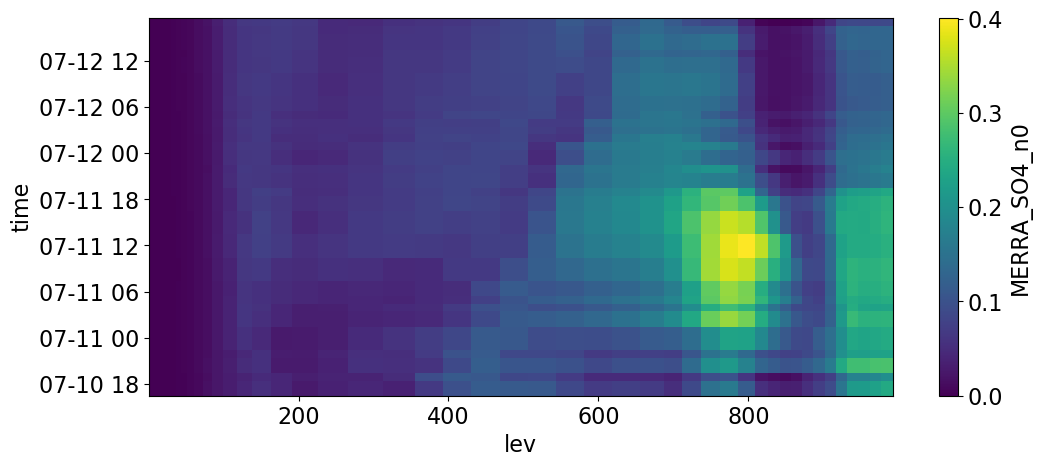

In [6]:
(ds.MERRA_SO4_n0/1e6).plot()

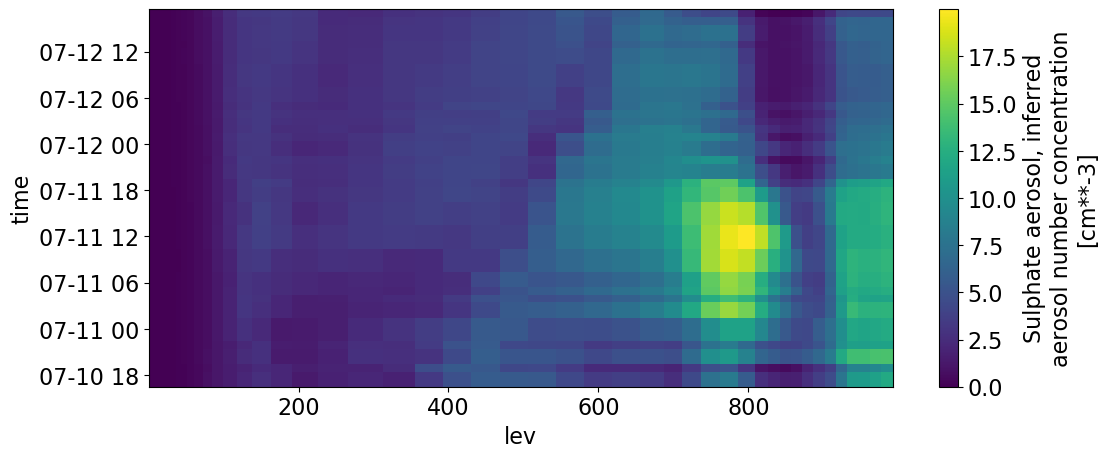

In [7]:
ds.MERRA_SO4_Na.plot()

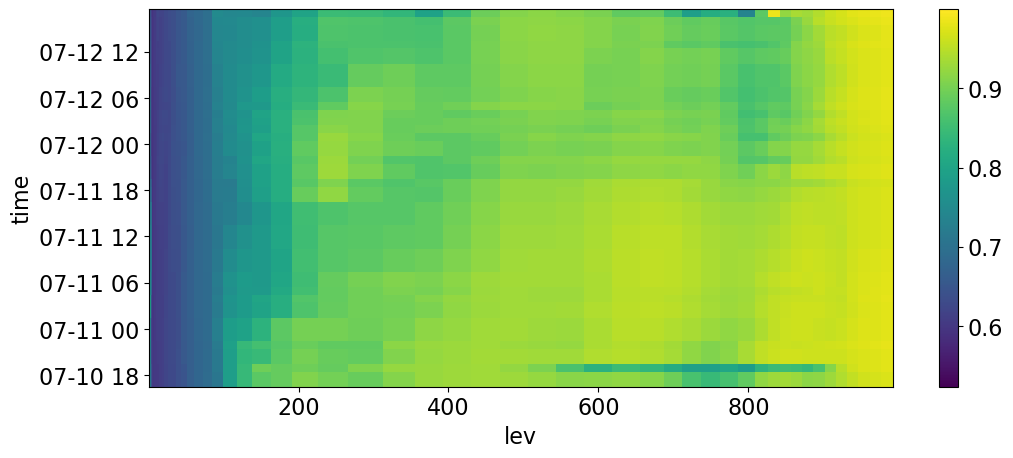

In [8]:
((ds['MERRA_acc_mass'] + ds['MERRA_akn_mass'] + ds['MERRA_crs_mass'])/ds['MERRA_Na_tot_mass']).plot()

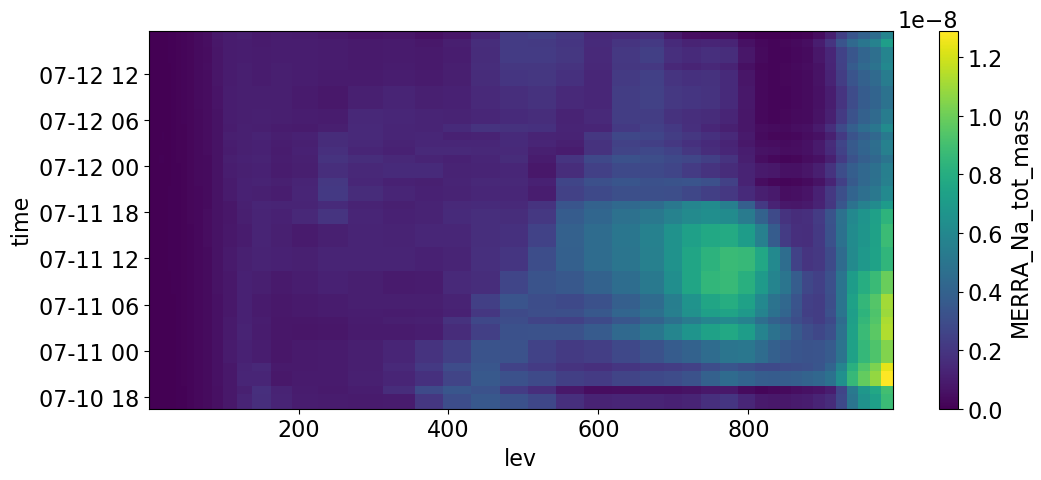

In [9]:
ds['MERRA_Na_tot_mass'].plot()

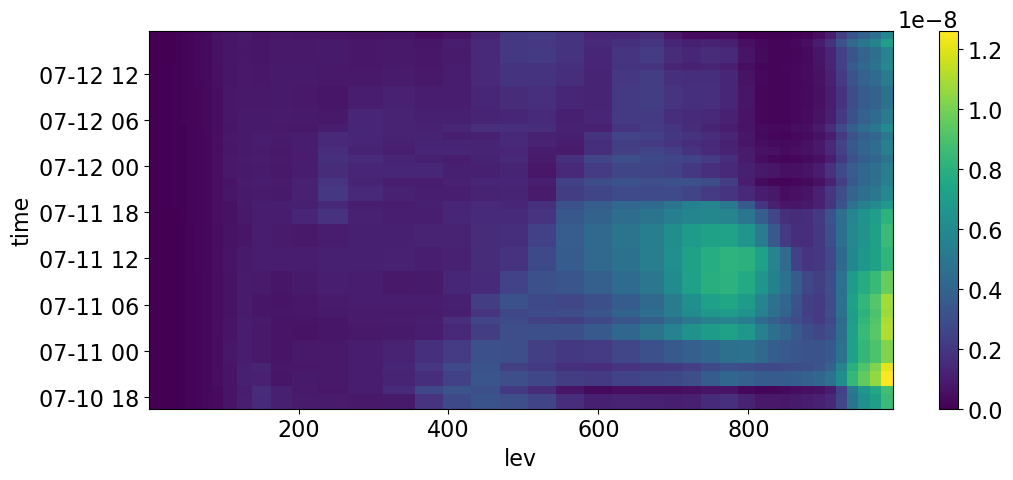

In [10]:
((ds['MERRA_acc_mass'] + ds['MERRA_akn_mass'] + ds['MERRA_crs_mass'])).plot()

In [11]:
ds = xr.open_dataset("/home/disk/eos4/jkcm/Data/CSET/ERA5/ERA5.pres.NEP.2015-08-11.nc")

In [13]:
ds.z

<xarray.DataArray 'z' (time: 24, level: 37, latitude: 101, longitude: 152)>
[13632576 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 199.8 200.1 200.4 200.7 ... 244.5 244.8 245.1
  * latitude   (latitude) float32 45.0 44.7 44.4 44.1 ... 15.9 15.6 15.3 15.0
  * level      (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * time       (time) datetime64[ns] 2015-08-11 ... 2015-08-11T23:00:00
Attributes:
    standard_name:  geopotential
    long_name:      Geopotential
    units:          m**2 s**-2